### Middleware

- Managing long conversations
- Dynamically change agent behaviour based on factors at runtime 
- Adding Human in the loop 

For all these we need a middleware. Middleware is basically a term that we use to describe functions that we use in between the loop at runtime. 

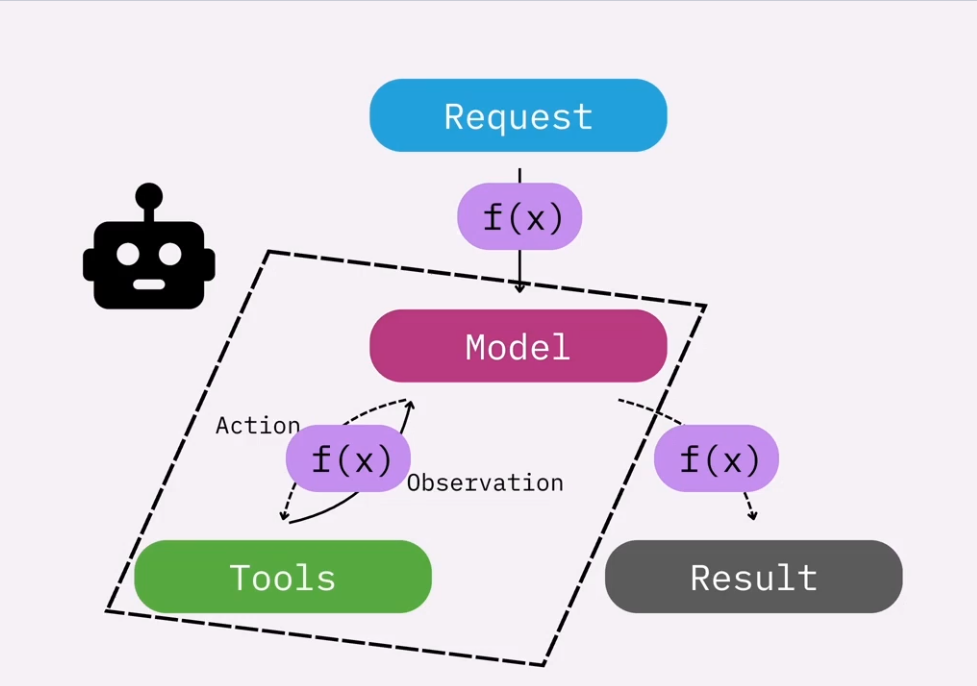


For example we can add a classifier for a customer facing agent which gives out advices. 

`Agent --- f{x} [ classifer middleware ] --- User`

Or add a human in the loop for approval incase of an agent that is tasked with processing refunds. 

`Agent --- f{x} [ Human in the loop middleware ] --- User`



**Manage Long Conversation**

Overtime as we add checkpointer and states to our agent we pile up the context of the model. It becomes very hard for the model to compile such huge context and also increases costs for us. In this scenario we can manage long conversations in many ways. 

One of them is summerisation. 


In [4]:
from langchain.agents import create_agent
from langchain_ollama import ChatOllama
# Load the model
model = ChatOllama(model="qwen3:1.7b", 
                   temperature=0,
                   validate_model_on_init=True,
                   seed=42)

tiny_model = ChatOllama(model="llama3.2:1b", 
                   temperature=0,
                   validate_model_on_init=True,
                   seed=42)

In [5]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import SummarizationMiddleware

agent = create_agent(
    model,
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            tiny_model,
            trigger=("tokens", 100),
            keep=("messages", 1)
        )
    ],
)

In [6]:
from langchain.messages import HumanMessage, AIMessage
from pprint import pprint

response = agent.invoke(
    {"messages": [
        HumanMessage(content="What is the capital of the moon?"),
        AIMessage(content="The capital of the moon is Lunapolis."),
        HumanMessage(content="What is the weather in Lunapolis?"),
        AIMessage(content="Skies are clear, with a high of 120C and a low of -100C."),
        HumanMessage(content="How many cheese miners live in Lunapolis?"),
        AIMessage(content="There are 100,000 cheese miners living in Lunapolis."),
        HumanMessage(content="Do you think the cheese miners' union will strike?"),
        AIMessage(content="Yes, because they are unhappy with the new president."),
        HumanMessage(content="If you were Lunapolis' new president how would you respond to the cheese miners' union?"),
        ]},
    {"configurable": {"thread_id": "1"}}
)

pprint(response)

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\nLunapolis.', additional_kwargs={}, response_metadata={}, id='b6133383-cad1-4a27-a787-3ad4ce462f57'),
              HumanMessage(content="If you were Lunapolis' new president how would you respond to the cheese miners' union?", additional_kwargs={}, response_metadata={}, id='3d11f4f5-2a30-49ba-9e4b-f35c6cc9cb9d'),
              AIMessage(content='As Lunapolis\' new president, addressing the cheese miners\' union would require a balance of collaboration, fairness, and long-term partnership. Here’s how I’d approach the situation:\n\n### 1. **Acknowledge the Union’s Role**  \n   Recognize the union’s vital role in protecting workers’ rights, ensuring fair wages, and maintaining safe working conditions. Emphasize that the company values its workforce and is committed to their well-being.\n\n### 2. **Prioritize Fairness and Transparency**  \n   Propose transparent negotiations to address concerns such as wa

In [7]:
print(response["messages"][0].content)

Here is a summary of the conversation to date:

Lunapolis.


Second one is trim or delete messages

In [8]:
from typing import Any
from langchain.agents import AgentState
from langchain.messages import RemoveMessage
from langgraph.runtime import Runtime
from langchain.agents.middleware import before_agent
from langchain.messages import ToolMessage

@before_agent
def trim_messages(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Remove all the tool messages from the state"""
    messages = state["messages"]

    tool_messages = [m for m in messages if isinstance(m, ToolMessage)]
    
    return {"messages": [RemoveMessage(id=m.id) for m in tool_messages]}

In [9]:
response = agent.invoke(
    {"messages": [
        HumanMessage(content="My device won't turn on. What should I do?"),
        ToolMessage(content="blorp-x7 initiating diagnostic ping…", tool_call_id="1"),
        AIMessage(content="Is the device plugged in and turned on?"),
        HumanMessage(content="Yes, it's plugged in and turned on."),
        ToolMessage(content="temp=42C voltage=2.9v … greeble complete.", tool_call_id="2"),
        AIMessage(content="Is the device showing any lights or indicators?"),
        HumanMessage(content="What's the temperature of the device?")
        ]},
    {"configurable": {"thread_id": "2"}}
)

pprint(response)

{'messages': [HumanMessage(content="Here is a summary of the conversation to date:\n\nMy device won't turn on. What should I do?", additional_kwargs={}, response_metadata={}, id='19ba156a-f3bd-4460-8705-fafa9f8c1b96'),
              HumanMessage(content="What's the temperature of the device?", additional_kwargs={}, response_metadata={}, id='6c11588e-7374-4fc6-8527-6889cbbae3f3'),
              AIMessage(content="If your device isn't turning on, here are the steps to troubleshoot:\n\n1. **Check Physical Damage**: Inspect the device for cracks, water ingress, or debris. If it's frozen, gently shake it to thaw it (if it's a portable device like a phone or laptop).  \n2. **Verify Power Source**:  \n   - **Charge the device** if it's not powered. Use a charger and cable.  \n   - Check if the power outlet is working by testing another device.  \n3. **Check for Obstructions**: Ensure the device isn't blocked by foreign objects.  \n4. **Reset or Force Restart**:  \n   - For smartphones/laptops

In [10]:
print(response["messages"][-1].content)

If your device isn't turning on, here are the steps to troubleshoot:

1. **Check Physical Damage**: Inspect the device for cracks, water ingress, or debris. If it's frozen, gently shake it to thaw it (if it's a portable device like a phone or laptop).  
2. **Verify Power Source**:  
   - **Charge the device** if it's not powered. Use a charger and cable.  
   - Check if the power outlet is working by testing another device.  
3. **Check for Obstructions**: Ensure the device isn't blocked by foreign objects.  
4. **Reset or Force Restart**:  
   - For smartphones/laptops: Press and hold the power button until the restart menu appears.  
   - For some devices, a hard reset (e.g., holding the power button for 10 seconds) may help.  
5. **Check Temperature**: If the device is frozen, let it warm up naturally (avoid direct sunlight) before trying to turn it on.  
6. **Test with a Different Charger/USB Port**: Sometimes, the issue is with the power source.  
7. **Contact Support**: If none o